In [83]:
import itertools
from collections import defaultdict
import networkx as nx
import math
import matplotlib.pyplot as plt

In [84]:
def manhattan_distance(x, y):
    return sum(abs(a - b) for a, b in zip(x, y))

def extract_candidate_distances(clients1, clients2, facilities1, facilities2, distance_fn):
    print("I'm inside extract candidates function")
    distances = set()
    for j in clients1 + clients2:
        for i in facilities1 + facilities2:
            distances.add(distance_fn(j, i))
    return sorted(distances)

In [85]:
def greedy_k_supplier(clients, facilities, k, R, distance_fn):
    """
    Greedy algorithm: Place centers such that all clients are within R.
    Each new facility covers as many uncovered clients as possible.
    """
    print("I'm inside greedy_s_supplier function")
    uncovered = set(clients)
    used_facilities = set()

    while uncovered and len(used_facilities) < k:
        # For each facility, count how many uncovered clients it can cover
        best_f, covered = None, set()
        for f in facilities:
            covered_now = {j for j in uncovered if distance_fn(j, f) <= R}
            if len(covered_now) > len(covered):
                best_f, covered = f, covered_now

        if not covered:
            return None  # Can't cover remaining clients with current R

        used_facilities.add(best_f)
        uncovered -= covered

    if uncovered:
        return None #cant satisfy all clients with radius r
    return used_facilities

In [86]:
def draw_bipartite_graph(G):
    # Extract nodes from each partition using node names
    left_nodes = [n for n in G.nodes if str(n).startswith('f1_')]
    right_nodes = [n for n in G.nodes if str(n).startswith('f2_')]

    pos = {}

    # Vertical positioning: evenly spaced
    for i, node in enumerate(left_nodes):
        pos[node] = (0, -i)
    for i, node in enumerate(right_nodes):
        pos[node] = (2, -i)

    plt.figure(figsize=(8, 6))
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, nodelist=left_nodes, node_color='skyblue', label='Time 1')
    nx.draw_networkx_nodes(G, pos, nodelist=right_nodes, node_color='lightgreen', label='Time 2')

    # Draw edges
    nx.draw_networkx_edges(G, pos, width=1.5)

    # Add labels
    nx.draw_networkx_labels(G, pos, font_size=10)

    plt.title("Bipartite Graph of Facility Movements")
    plt.axis('off')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [87]:
def build_bipartite_graph(facilities1, facilities2, B, distance_fn):
    print("Building bipartite graph")
    G = nx.Graph()
    for i, f1 in enumerate(facilities1):
        for j, f2 in enumerate(facilities2):
            if distance_fn(f1, f2) <= B:
                G.add_edge(f"f1_{i}", f"f2_{j}")
    return G

def has_valid_matching(G):
    if G.number_of_edges() == 0:
        return False

    # Extract left and right nodes
    left = [n for n in G.nodes if str(n).startswith("f1_")]
    right = [n for n in G.nodes if str(n).startswith("f2_")]

    try:
        matching = nx.bipartite.maximum_matching(G, top_nodes=left)
        matched_pairs = len(matching) // 2  # Each pair appears twice

        # Match size should be equal to the smaller side
        required_match_size = min(len(left), len(right))
        if matched_pairs == required_match_size:
            return True
        else:
            print("No possible movements")
            return False

    except nx.NetworkXPointlessConcept:
        return False

In [88]:
def is_feasible(R, B, clients1, clients2, facilities1, facilities2, k, distance_fn=manhattan_distance):
    S1 = greedy_k_supplier(clients1, facilities1, k, R, distance_fn)
    S2 = greedy_k_supplier(clients2, facilities2, k, R, distance_fn)
    if S1 is None or S2 is None:
        print("Cant cover all clients")
        return False

    G = build_bipartite_graph(list(S1), list(S2), B, distance_fn)
    draw_bipartite_graph(G)
    return has_valid_matching(G)

In [89]:
def binary_search_R_star(clients1, clients2, facilities1, facilities2, B, k, distance_fn=manhattan_distance):
    candidates = extract_candidate_distances(clients1, clients2, facilities1, facilities2, distance_fn)
    low, high = 0, len(candidates) - 1
    best_R = None

    while low <= high:
        mid = (low + high) // 2
        print(f"Checking if {candidates[mid]} is feasible")
        R = candidates[mid]
        if is_feasible(R, B, clients1, clients2, facilities1, facilities2, k, distance_fn):
            best_R = R
            high = mid - 1
        else:
            low = mid + 1

    return best_R

I'm inside extract candidates function
Checking if 5 is feasible
I'm inside greedy_s_supplier function
I'm inside greedy_s_supplier function
Building bipartite graph


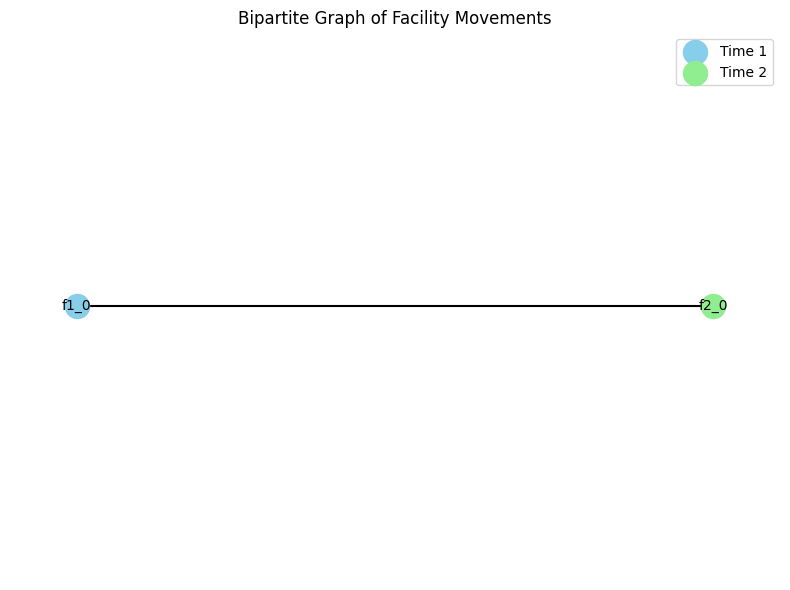

Checking if 2 is feasible
I'm inside greedy_s_supplier function
I'm inside greedy_s_supplier function
Building bipartite graph


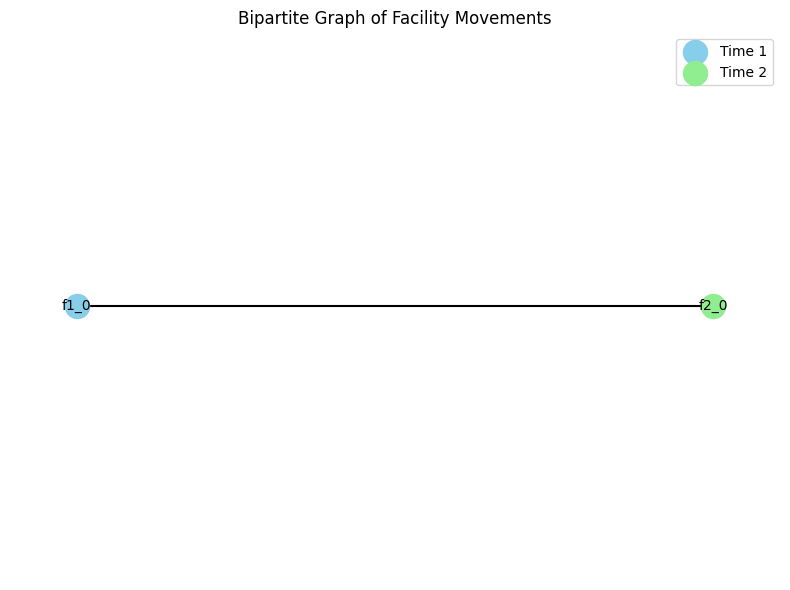

Checking if 1 is feasible
I'm inside greedy_s_supplier function
I'm inside greedy_s_supplier function
Building bipartite graph


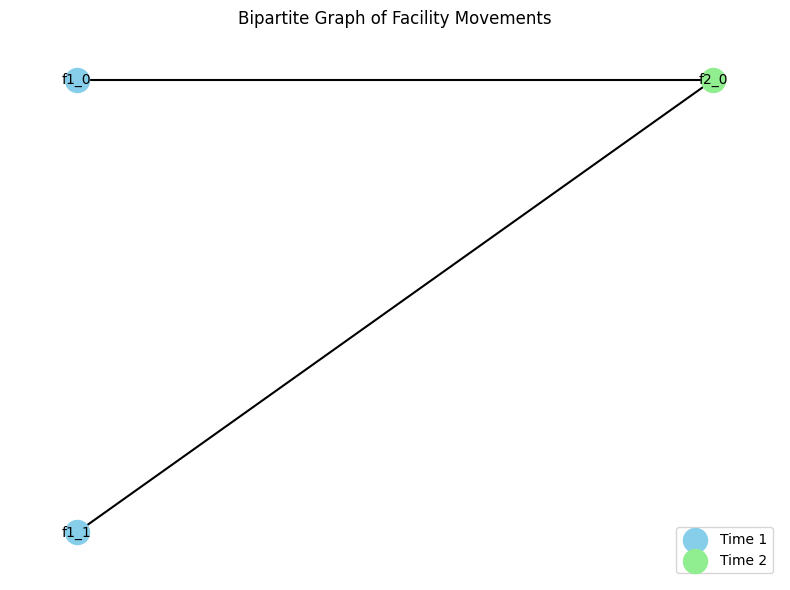

Guessed R* (minimum service radius): 1


In [97]:
clients1 = [(0, 0), (1, 2)]      # Clients at time step 1
clients2 = [(5, 5), (6, 6)]      # Clients at time step 2

facilities1 = [(0, 1), (2, 2), (3, 0)]  # Facilities at time 1
facilities2 = [(5, 6), (6, 5), (4, 4)]  # Facilities at time 2

k = 2  # Number of facilities to open per time step
B = 10  # Movement bound between facilities

R_star = binary_search_R_star(clients1, clients2, facilities1, facilities2, B, k, distance_fn=manhattan_distance)
print("Guessed R* (minimum service radius):", R_star)